# Inverse Engineering 2: ADC Quantization Step Retrieval

In [1]:
## Import libraries, set random seed for reproducibility, and define device and parameters
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
# include parent dir
import sys
sys.path.append('..')
from camflow import OpticalFilter, ADC, Demosaic
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device("cpu")
# Parameters
H, W = 800, 800

(1) Init + Training

In [2]:
# Ground-truth step size = 0.1, input = random image in [0,1]
gt_step_size = 0.1
adc_input = torch.rand(1, H, W)
quantized = torch.floor(adc_input / gt_step_size) 
num_iters = 200
adc_model = ADC(init_step=0.5).to(device)
opt = optim.Adam(adc_model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=num_iters)

# print(f"Ground-truth step size: {gt_step_size}")
# print(f"Input: {adc_input.squeeze().detach().numpy()}")
# print(f"Quantized: {quantized.squeeze().detach().numpy()}")

losses_adc = []
for i in range(num_iters):
    opt.zero_grad()
    pred = adc_model(adc_input)
    loss = ((pred - quantized)**2).mean()
    loss.backward()
    opt.step()
    scheduler.step()
    losses_adc.append(loss.item())

    # # print pred
    # if (i+1) % 200 == 0:
    #     print(f"pred = {pred.squeeze().detach().numpy()}")

    # # print gradient of step size
    # if (i+1) % 200 == 0:
    #     print(f"grad step size: {adc_model.step_size._grad.item()}")
    if (i+1) % 50 == 0:
        print(f"Iteration {i+1}, Loss: {loss.item():.6f}, Step size: {adc_model.step_size.item():.4f}")

Iteration 50, Loss: 0.686273, Step size: 0.1163
Iteration 100, Loss: 0.016295, Step size: 0.1006
Iteration 150, Loss: 0.001097, Step size: 0.1000
Iteration 200, Loss: 0.000320, Step size: 0.1000


(2) Plot & Save output

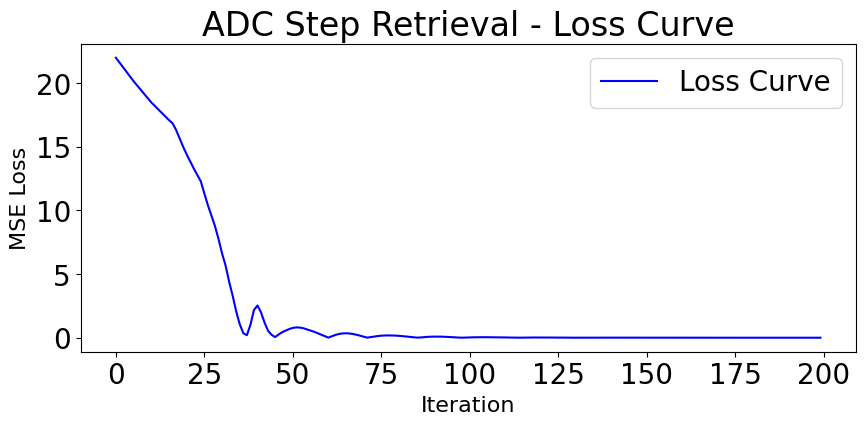

<Figure size 640x480 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

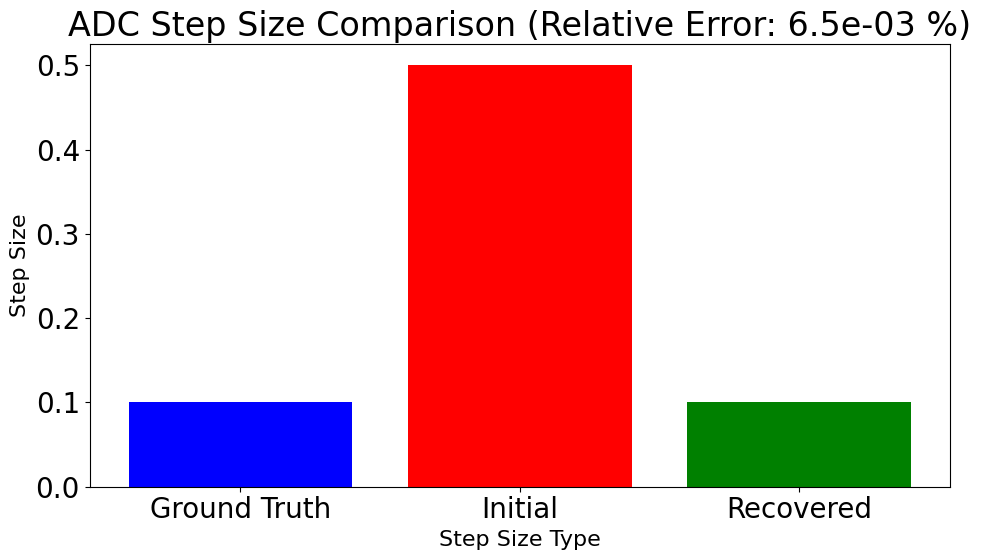

<Figure size 640x480 with 0 Axes>

In [6]:
import os
import matplotlib.pyplot as plt

# Create a directory called 'result' if it doesn't exist
if not os.path.exists('results'):
    os.makedirs('results')

# Plot results for ADC Retrieval
# Loss Curve
plt.figure(figsize=(10, 4))
plt.rcParams.update({'font.size': 20})
# set large label size to 14
plt.rcParams.update({'axes.labelsize': 16})
plt.subplot(1, 1, 1)
plt.plot(losses_adc, label="Loss Curve", color="blue")
plt.title("ADC Step Retrieval - Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.legend()

# Save loss curve
plt.savefig('results/adc_loss_curve.png')
plt.show()
# Clear plot
plt.clf()

# ADC Step Size Recovery Plot
plt.figure(figsize=(15, 5))

# Combined ADC Step Size Bar Plot
plt.figure(figsize=(10, 6))

# Data for the bars
labels = ['Ground Truth', 'Initial', 'Recovered']
values = [gt_step_size, 0.5, adc_model.step_size.item()]
colors = ['blue', 'red', 'green']

# Create the bar plot
plt.bar(labels, values, color=colors)

# Add title and labels
rel_error = (gt_step_size - adc_model.step_size.item()) / gt_step_size * 100
formatted_error = f"{rel_error:.1e}"  # Use scientific notation
plt.title(f"ADC Step Size Comparison (Relative Error: {formatted_error} %)")
plt.ylabel("Step Size")
plt.xlabel("Step Size Type")

# Save the plot
plt.tight_layout()
plt.savefig('results/adc_step_size_opt.png')
plt.show()
# Clear plot
plt.clf()
